In [22]:
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from matplotlib.ticker import ScalarFormatter

In [23]:
%run 00_data_preprocessing.ipynb

In [24]:
dir_path = "results/figures/section3/"
os.makedirs(dir_path, exist_ok=True)

In [25]:
def set_scientific_yticks(ax):
    """Force y-axis to show scientific notation in 10^x format"""
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Figure S3

In [26]:
B16_fucci = pd.read_csv("../../data/tumor/B16_fucci.csv")
B16_fucci.tail()

,Experiment,Condition,id,day,tumor_volume,mouse_cage,mouse_id,"L (tumor 1, mm)","S (tumor 1, mm)","H (tumor 1, mm)",...,"L (tumor 2, mm)","S (tumor 2, mm)","H (tumor 2, mm)","volume (tumor 2, mm3)","L (tumor 3, mm)","S (tumor 3, mm)","H (tumor 3, mm)","volume (tumor 3, mm3)","total tumor volume (tumor 1 + tumor 2, mm3)",Remarks
193,B16-fucci,TST_2.0×10^7,1,7,288.3,5,1,10.8,10.2,5.0,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,288.398206,NaN
194,B16-fucci,TST_2.0×10^7,2,7,196.6,4,3,7.4,9.2,4.5,...,3.1,5.0,2.3,18.666296,2.7,5.0,2.5,17.671459,179.076017,Three tumor nodules were observed.
195,B16-fucci,TST_2.0×10^7,3,7,219.7,5,5,13.0,9.5,3.4,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,219.859126,NaN
196,B16-fucci,TST_2.0×10^7,4,7,106.5,7,4,8.2,7.3,3.4,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,106.564917,NaN
197,B16-fucci,TST_2.0×10^7,5,7,7.3,11,1,4.0,5.0,0.7,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,7.330383,NaN


In [27]:
B16_fucci['Condition'].unique()

array(['Untreated', 'TST_1.0×10^6', 'TST_2.0×10^6', 'TST_5.0×10^6',
       'TST_1.0×10^7', 'TST_2.0×10^7'], dtype=object)

In [28]:
# Condition mapping
condition_labels = {
    'Untreated': 'Untreated',
    'TST_1.0×10^6': r'$1.0 \times 10^{6}$',
    'TST_2.0×10^6': r'$2.0 \times 10^{6}$',
    'TST_5.0×10^6': r'$5.0 \times 10^{6}$',
    'TST_1.0×10^7': r'$1.0 \times 10^{7}$',
    'TST_2.0×10^7': r'$2.0 \times 10^{7}$'
}

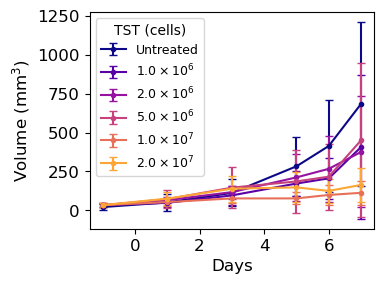

In [29]:
plt.figure(figsize=(4, 3))
colors = plt.cm.plasma(np.linspace(0, 0.8, len(B16_fucci['Condition'].unique())))

for i, cond in enumerate(B16_fucci['Condition'].unique()):
    plt.errorbar(
        tumor_volume(B16_fucci, cond)['day'],
        tumor_volume(B16_fucci, cond)['mean'],
        yerr=tumor_volume(B16_fucci, cond)['std'],
        label=condition_labels.get(cond, cond),   # ←ここで変換
        capsize=3, markersize=3, fmt='o-', color=colors[i]
    )
plt.legend(title="TST (cells)", fontsize=9, title_fontsize=10)
#plt.yscale('log')
#plt.ylim([1e1,3e3])
plt.xlabel('Days')
plt.ylabel('Volume (mm$^3$)')

plt.tight_layout()
plt.savefig(os.path.join(dir_path, "figS_fucci.pdf"), dpi=300, bbox_inches='tight')

# Figure 3

In [30]:
t_start = 2  
def tst_pulse(t, dose_list, dose_days, delta_t):
    """Return the TST input function F(t), based on dose schedule and delivery window."""
    total = 0
    for dose, day in zip(dose_list, dose_days):
        if day + t_start <= t < day + t_start + delta_t:
            total += dose / delta_t
    return total

In [31]:
# Model: Saturable Suppression by MDSCs
def model(y, t, dose_list, dose_days, delta_t, params):
    k_s, e_p, d_e, d_d, d_s, d_m, m_f, k_m = params
    V, E, D, S, M = y
    F_t = tst_pulse(t, dose_list, dose_days, delta_t)

    # ===ODE Model===
    dVdt = v_r * V * np.log(v_k / V) - k_s * S * V
    dEdt = F_t + e_p * E * V**2 / (V**2 + k_v)  - d_m * E * M /(k_m+M) - d_e * E
    dDdt = d_m * E * M /(k_m+M) + d_e * E - d_d * D
    dSdt = E - d_s * S
    dMdt = m_f * F_t + m_v * V - m_d * M

    return [dVdt, dEdt, dDdt, dSdt, dMdt]

In [32]:
def vis_act(sol, out_dir=None, figure_name=None):
    V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
    T_sol = E_sol + D_sol

    # === Plot ===
    plt.figure(figsize=(16, 4), dpi=200)
    plt.rcParams["font.size"] = 12

    # --- Panel A: Tumor volume ---
    ax1 = plt.subplot(1, 4, 1)
    ax1.plot(t_eval, V_sol, label='Model', color='blue', linewidth=2)
    ax1.set_xlabel("Days")
    ax1.set_ylabel("B16 (cells)")
    ax1.set_title("B16 Dynamics")
    ax1.legend()
    set_scientific_yticks(ax1)

    # --- Panel B: MDSC ---
    ax2 = plt.subplot(1, 4, 2)
    ax2.plot(t_eval, M_sol, label='Model', color='blue')
    ax2.set_xlabel("Days")
    ax2.set_ylabel("MDSC (cells)")
    ax2.set_title("MDSC Dynamics")
    ax2.legend()
    set_scientific_yticks(ax2)

    # --- Panel C: TST ---
    ax3 = plt.subplot(1, 4, 3)
    ax3.plot(t_eval, T_sol, label='Total (E+D)', color='blue', linewidth=2)
    ax3.plot(t_eval, E_sol, label='Effector (E)', color='skyblue', linewidth=2)
    ax3.plot(t_eval, D_sol, label='Exhausted (D)', color='gray', linewidth=2)
    ax3.set_xlabel('Days')
    ax3.set_ylabel('TST (cells)')
    ax3.set_title('TST Dynamics')
    ax3.legend()
    set_scientific_yticks(ax3)

    # --- Panel D: Suppression Effect ---
    ax4 = plt.subplot(1, 4, 4)
    ax4.plot(t_eval, S_sol, label='Model', color='blue', linewidth=2)
    ax4.set_xlabel('Days')
    ax4.set_ylabel('Tumor Suppression')
    ax4.set_title('Tumor Suppression')
    ax4.legend()
    set_scientific_yticks(ax4)

    plt.tight_layout()

    # === Save if out_dir is provided ===
    if out_dir is not None and figure_name is not None:
        os.makedirs(out_dir, exist_ok=True)
        pdf_path = os.path.join(out_dir, f"{figure_name}.pdf")
        jpeg_path = os.path.join(out_dir, f"{figure_name}.jpeg")
        plt.savefig(pdf_path, dpi=300)
        plt.savefig(jpeg_path, dpi=300)
        print(f"Figure saved: {pdf_path}, {jpeg_path}")

    plt.show()

# Parameter

In [33]:
# ==Fixed param ==
v_r = 9.75e-2
v_k = 1.97e+10
m_v = 3.00e-2
m_d = 0.35

# Other article param
k_v = 2.02e7

t_start = 2 
delta_t = 1

# Optimized param
param = np.array([
    1.2699e-07, 1.5558e+00, 8.9530e-01, 4.9183e-01,
    7.6388e-01, 1.6922e+00, 3.9186e+00, 4.4873e+06
])

# Fig 3a Simulation

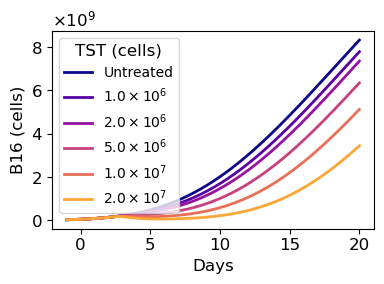

In [34]:
# Simulation Setup
t_eval = np.arange(-1, 20.01, 0.01)
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]

dose_days = [0]
delta_t   = 1   

# doses
dose_values = [0, 1e6, 2e6, 5e6, 1e7, 2e7]
results = {}

# --- Plot ---
plt.figure(figsize=(4, 3))
#plt.rcParams["font.size"] = 18

colors = plt.cm.plasma(np.linspace(0, 0.8, len(dose_values)))

for i, dose in enumerate(dose_values):
    dose_list = [dose]
    sol = odeint(model, y0, t_eval, args=(dose_list, dose_days, delta_t, param), hmax=0.001)
    V_sol = sol[:, 0]
    results[dose] = V_sol

    # --- 修正: legend label を LaTeX表記に ---
    if dose == 0:
        labels = "Untreated"
    else:
        exponent = int(np.log10(dose))
        coeff = dose / 10**exponent
        labels = fr"$ {coeff:.1f} \times 10^{{{exponent}}}$"
    plt.plot(t_eval, V_sol, label=labels, color=colors[i], linewidth=2)
    
plt.xlabel('Days')
plt.ylabel('B16 (cells)')

# === apply scientific notation on y-axis ===
ax = plt.gca()
set_scientific_yticks(ax)

plt.legend(title='TST (cells)', fontsize=10)#, loc='center left', bbox_to_anchor=(1, 0.6))
plt.tight_layout()

pdf_path = os.path.join(dir_path, f"fig3a.pdf")
plt.savefig(pdf_path, dpi=1200)
plt.show()

# Fig 3b 

In [35]:
def format_sci(value):
    """a × 10^b"""
    if value == 0:
        return "0"
    exponent = int(np.floor(np.log10(value)))
    coeff = value / 10**exponent
    return fr"{coeff:.1f} \times 10^{{{exponent}}}"

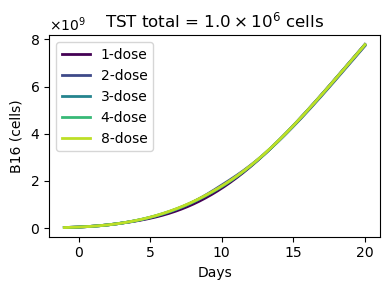

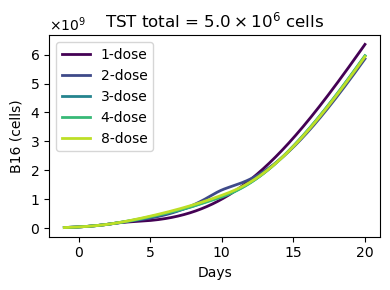

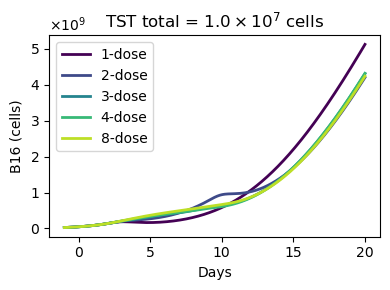

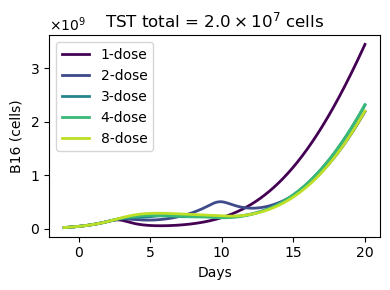

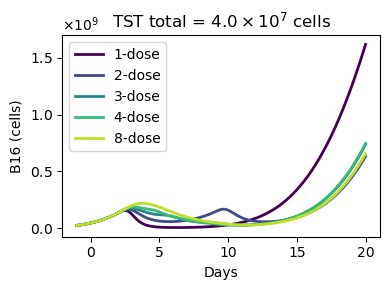

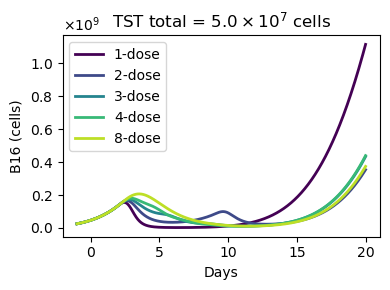

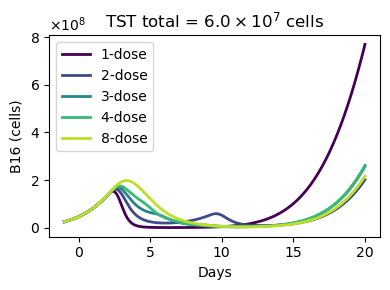

In [36]:
# === Dosing schedule ===
t_eval = np.arange(-1, 20.01, 0.01)
total_dose_list = [1e6, 5e6, 1e7, 2e7, 4e7, 5e7, 6e7]
for total_dose in total_dose_list:
    dose_schedules = {
        "1-dose": ([0], [total_dose]),
        "2-dose": ([0, 7], [total_dose/2]*2),
        "3-dose": ([0, 3, 6], [total_dose/3]*3),
        "4-dose": ([0, 2, 4, 6], [total_dose/4]*4),
        "8-dose": ([0, 1, 2, 3, 4, 5, 6, 7], [total_dose/8]*8)
    }
    
    # === Simulation ===
    plt.rcParams["font.size"] = 10
    
    plt.figure(figsize=(4, 3))
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(dose_schedules)))
    
    for (label, (days, doses)), color in zip(dose_schedules.items(), colors):
        t_eval = np.arange(-1, 20.01, 0.01)
        sol = odeint(model, y0, t_eval, args=(doses, days, delta_t, param), hmax=0.001)
        V_sol = sol[:, 0]
        plt.plot(t_eval, V_sol, label=label, color=color, linewidth=2)
    
    plt.xlabel('Days')
    plt.ylabel('B16 (cells)')
    #plt.yscale('log')

    sci_title = format_sci(total_dose)
    plt.title(fr"TST total = ${sci_title}$ cells")
    plt.legend(title="Schedule")
    plt.tight_layout()

    # === apply scientific notation on y-axis ===
    ax = plt.gca()
    set_scientific_yticks(ax)

    plt.legend(fontsize=10)#, loc='center left', bbox_to_anchor=(1, 0.6))
    plt.tight_layout()

    # --- Save ---
    filename_base = f"{int(total_dose):.0e}".replace("+0", "").replace(".0", "").replace("e", "e")
    #plt.savefig(os.path.join(save_dir_3_1, f"{filename_base}_dose.pdf"), dpi=300, bbox_inches='tight')
    #plt.savefig(os.path.join(save_dir_3_1, f"{filename_base}_dose.png"), dpi=300, bbox_inches='tight')
    pdf_path = os.path.join(dir_path, f"figS3b_{filename_base}_dose.pdf")
    #jpeg_path = os.path.join(dir_path, f"fig3b_{filename_base}_dose.jpeg")
    plt.savefig(pdf_path, dpi=1200)

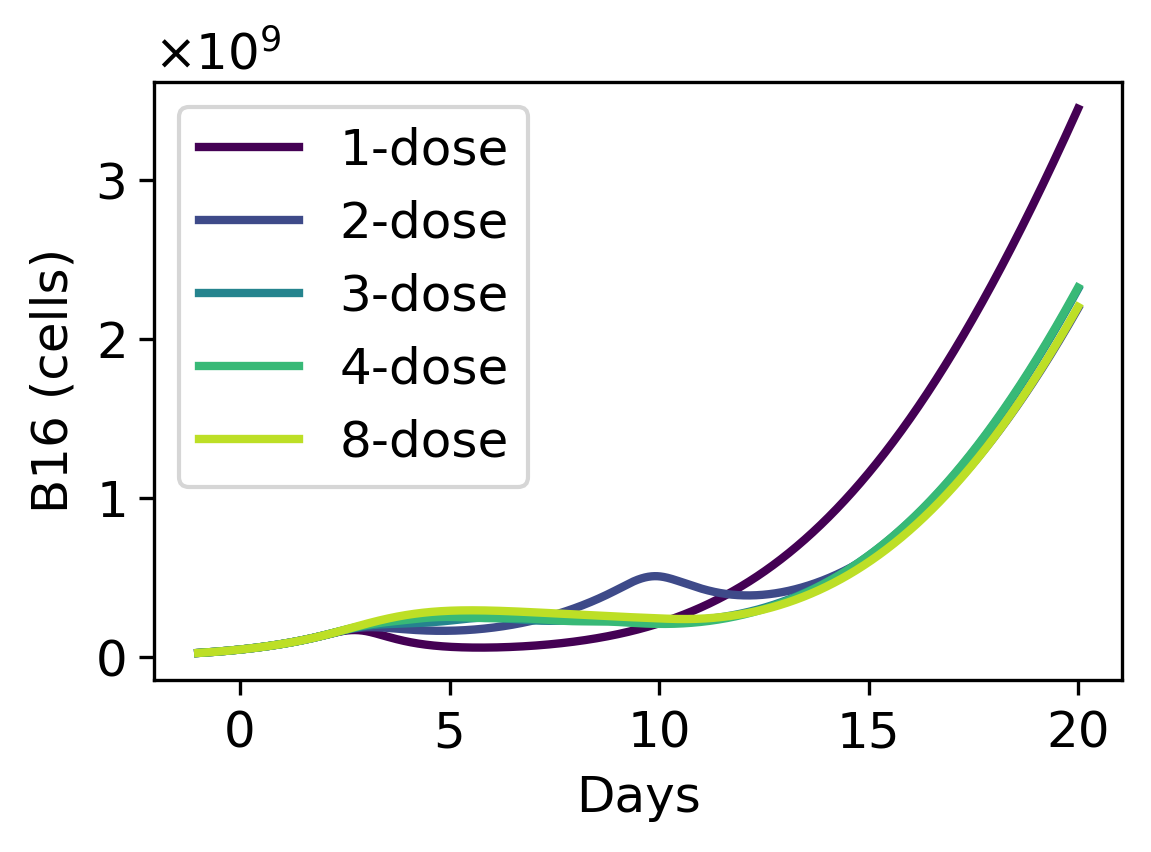

In [37]:
# === Dosing schedule ===
t_eval = np.arange(-1, 20.01, 0.01)
total_dose_list = [2e7]
for total_dose in total_dose_list:
    dose_schedules = {
        "1-dose": ([0], [total_dose]),
        "2-dose": ([0, 7], [total_dose/2]*2),
        "3-dose": ([0, 3, 6], [total_dose/3]*3),
        "4-dose": ([0, 2, 4, 6], [total_dose/4]*4),
        "8-dose": ([0, 1, 2, 3, 4, 5, 6, 7], [total_dose/8]*8)
    }
    
    # === Simulation ===
    plt.rcParams["font.size"] = 12
    
    plt.figure(figsize=(4, 3), dpi=300)
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(dose_schedules)))
    
    for (label, (days, doses)), color in zip(dose_schedules.items(), colors):
        t_eval = np.arange(-1, 20.01, 0.01)
        sol = odeint(model, y0, t_eval, args=(doses, days, delta_t, param), hmax=0.001)
        V_sol = sol[:, 0]
        plt.plot(t_eval, V_sol, label=label, color=color, linewidth=2)
    
    plt.xlabel('Days')
    plt.ylabel('B16 (cells)')
    #plt.yscale('log')

    sci_title = format_sci(total_dose)
    #plt.title(fr"TST total = ${sci_title}$ cells")
    plt.legend(title="Schedule")
    plt.tight_layout()

    # === apply scientific notation on y-axis ===
    ax = plt.gca()
    set_scientific_yticks(ax)

    plt.legend()#, loc='center left', bbox_to_anchor=(1, 0.6))
    plt.tight_layout()
    filename_base = f"{int(total_dose):.0e}".replace("+0", "").replace(".0", "").replace("e", "e")
    pdf_path = os.path.join(dir_path, f"fig3b_{filename_base}_dose.pdf")

    plt.savefig(pdf_path, dpi=1200)

# Fig 3C

In [38]:
# Baseline volume at reference_time (Day 3)
reference_time = t_start + delta_t  # 2 + 1 = 3 days
sol_base = odeint(model, y0, t_eval, args=([0], [0], delta_t, param))
V_ref = np.interp(reference_time, t_eval, sol_base[:, 0])

# Fine-grained parameter grid
second_days = np.arange(0, 10, 1)          # Days 0 to 10
second_doses = np.arange(5e6, 4.1e7, 0.5e7)
#   # Doses from 0.5e7 to 4.0e7 in steps of 0.5e7

pfs_matrix_2 = np.zeros((len(second_doses), len(second_days)))

# Compute PFS for each combination
for i, dose2 in enumerate(second_doses):
    for j, day2 in enumerate(second_days):
        doses = [1e7, dose2]
        days = [0, int(day2)]
        sol = odeint(model, y0, t_eval, args=(doses, days, delta_t, param), hmax=0.001)
        V = sol[:, 0]
        mask = (t_eval > reference_time) & (V >= V_ref)
        pfs_matrix_2[i, j] = (np.min(t_eval[mask]) - reference_time) if np.any(mask) else (t_eval[-1] - reference_time)

# Prepare DataFrame
pfs_df_new_2 = pd.DataFrame(pfs_matrix_2, 
                      index=[f"{d/1e7:.1f}e7" for d in second_doses],
                      columns=[f"Day {int(d)}" for d in second_days])

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1612035695768D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1612035695768D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1612035695768D-15


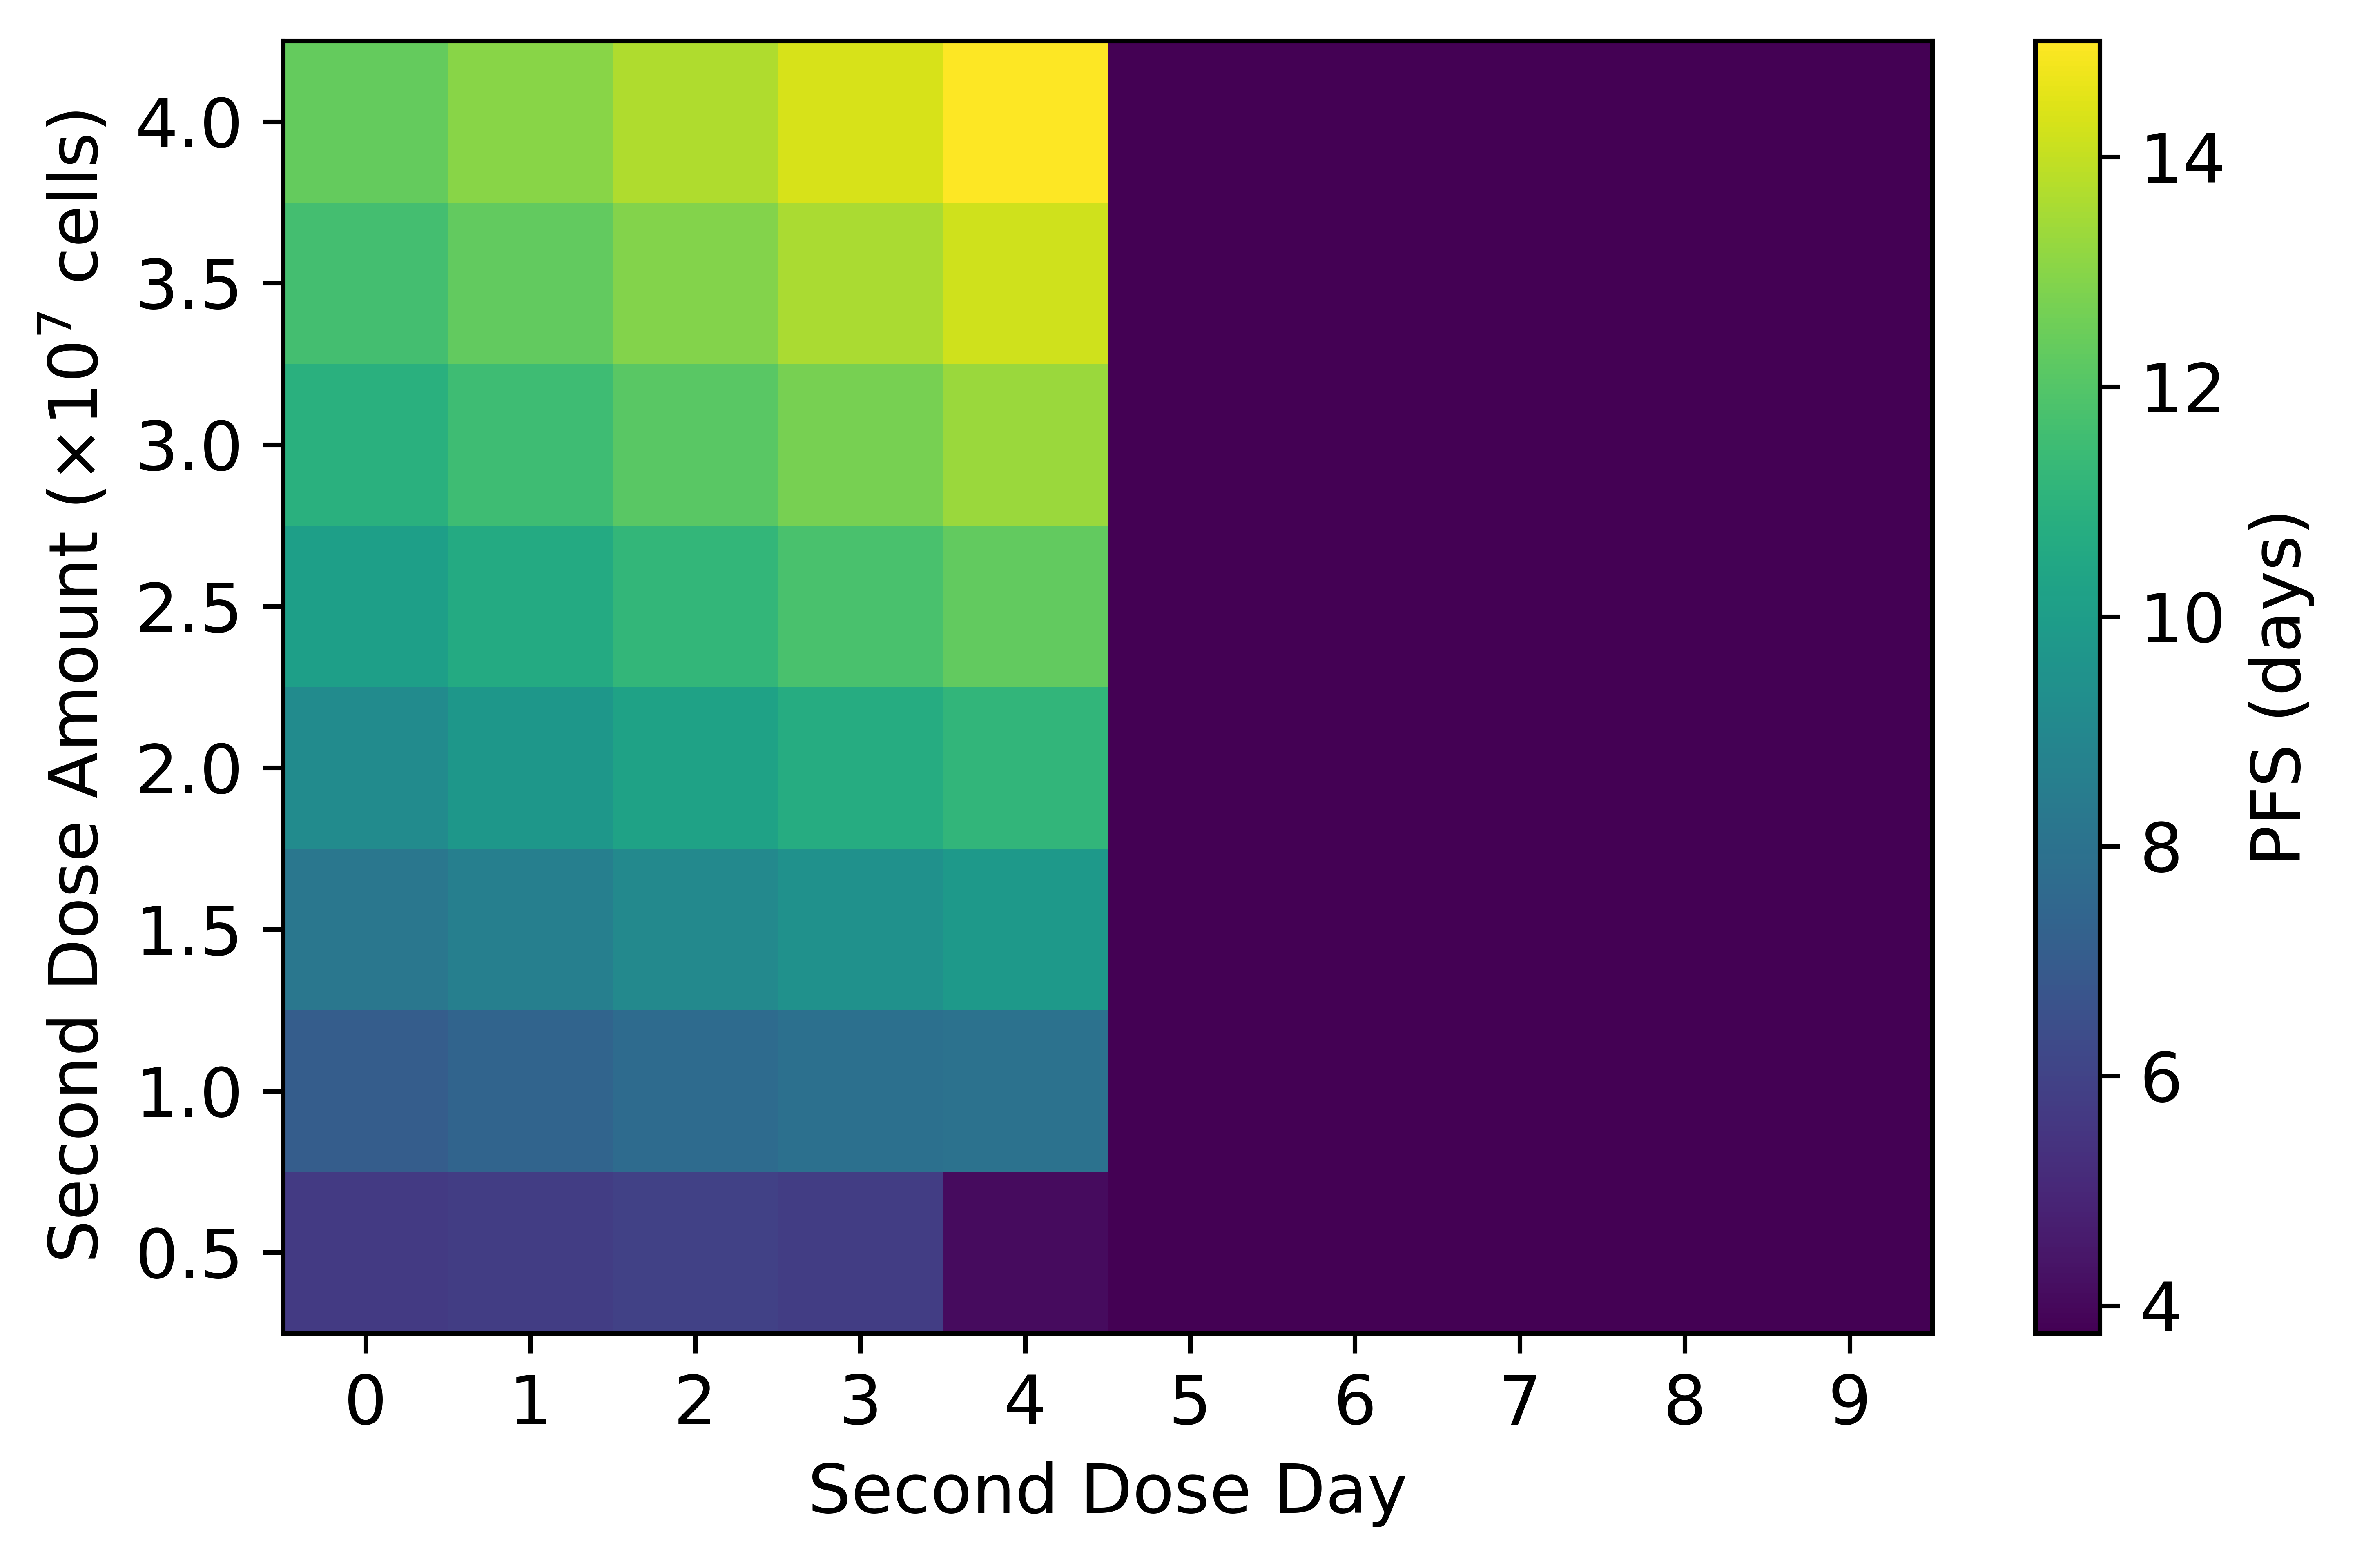

In [39]:
plt.figure(figsize=(6, 4), dpi=1000)
plt.imshow(pfs_matrix_2, origin='lower', aspect='auto')
plt.colorbar(label='PFS (days)')

plt.xticks(np.arange(len(second_days)), second_days)
yticklabels = [f"{d/1e7:.1f}" for d in second_doses]
plt.yticks(np.arange(len(second_doses)), yticklabels)
plt.xlabel('Second Dose Day')
plt.ylabel('Second Dose Amount ($\\times 10^7$ cells)')

#plt.title('Figure 3D: Fine-Grained PFS Heatmap (Baseline Day 3)')
plt.tight_layout()

pdf_path = os.path.join(dir_path, f"fig3c_PFS.pdf")
plt.savefig(pdf_path, dpi=1200)

In [40]:
# Simulation settings
t_eval = np.arange(-1, 35.01, 0.01)
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]]

# Fine-grained parameter grid
second_days = np.arange(0, 10, 1)
second_doses = np.arange(0.5e7, 5.1e7, 0.5e7)

# Compute final tumor volume at end of simulation (t = max t_eval)
final_vol_matrix_2 = np.zeros((len(second_doses), len(second_days)))

for i, dose2 in enumerate(second_doses):
    for j, day2 in enumerate(second_days):
        doses = [1e7, dose2]
        days = [0, int(day2)]
        sol = odeint(model, y0, t_eval, args=(doses, days, delta_t, param))
        final_vol_matrix_2[i, j] = sol[-1, 0]

# Create DataFrame for display
final_df_2 = pd.DataFrame(final_vol_matrix_2,
                        index=[f"{d/1e7:.1f}e7" for d in second_doses],
                        columns=[f"Day {int(d)}" for d in second_days])

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1193117149186D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2000000000000D+01   r2 =  0.1193117149186D-15


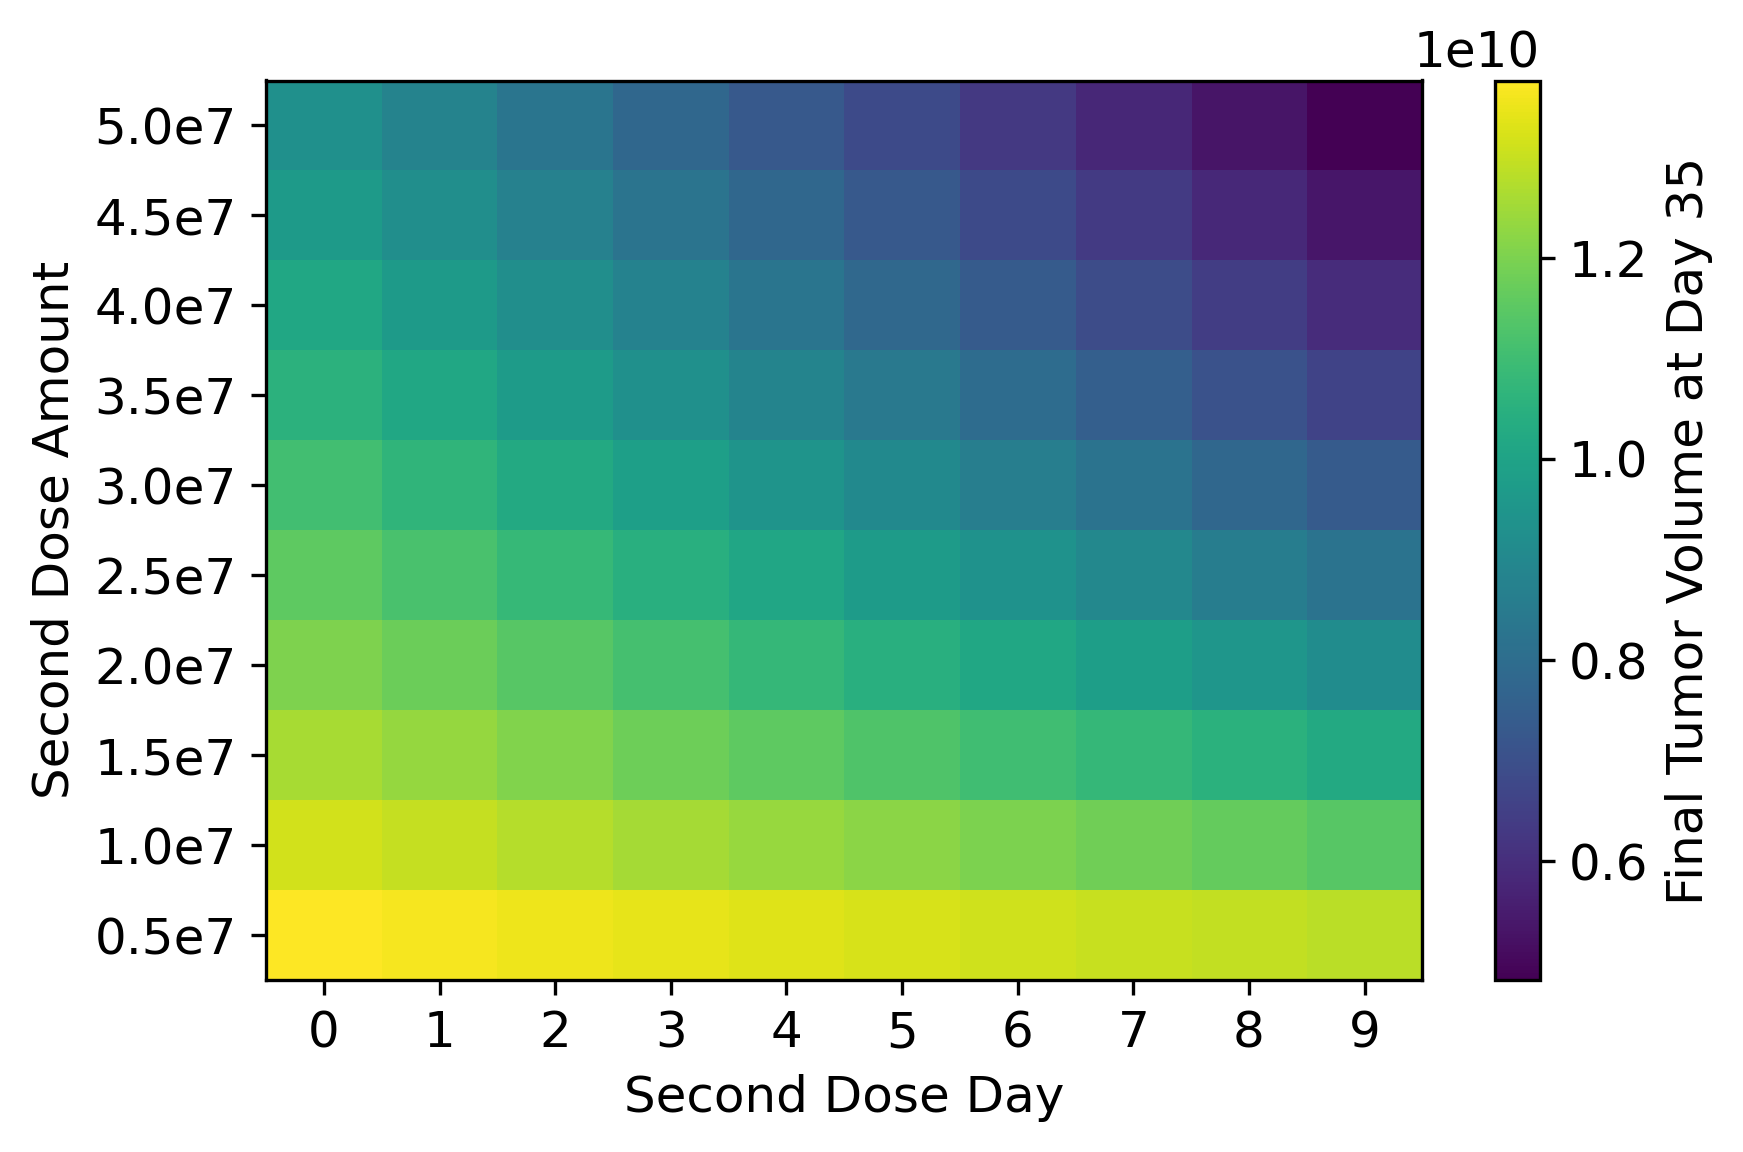

In [41]:
# Plot heatmap
plt.figure(figsize=(6, 4), dpi=300)
plt.imshow(final_vol_matrix_2, origin='lower', aspect='auto')
plt.colorbar(label='Final Tumor Volume at Day 35')
plt.xticks(np.arange(len(second_days)), second_days)
plt.yticks(np.arange(len(second_doses)), [f"{d/1e7:.1f}e7" for d in second_doses])
plt.xlabel('Second Dose Day')
plt.ylabel('Second Dose Amount')
#plt.title('Tumor Volume Heatmap at Day 35')
plt.tight_layout()
plt.show()

# Fig. 3D

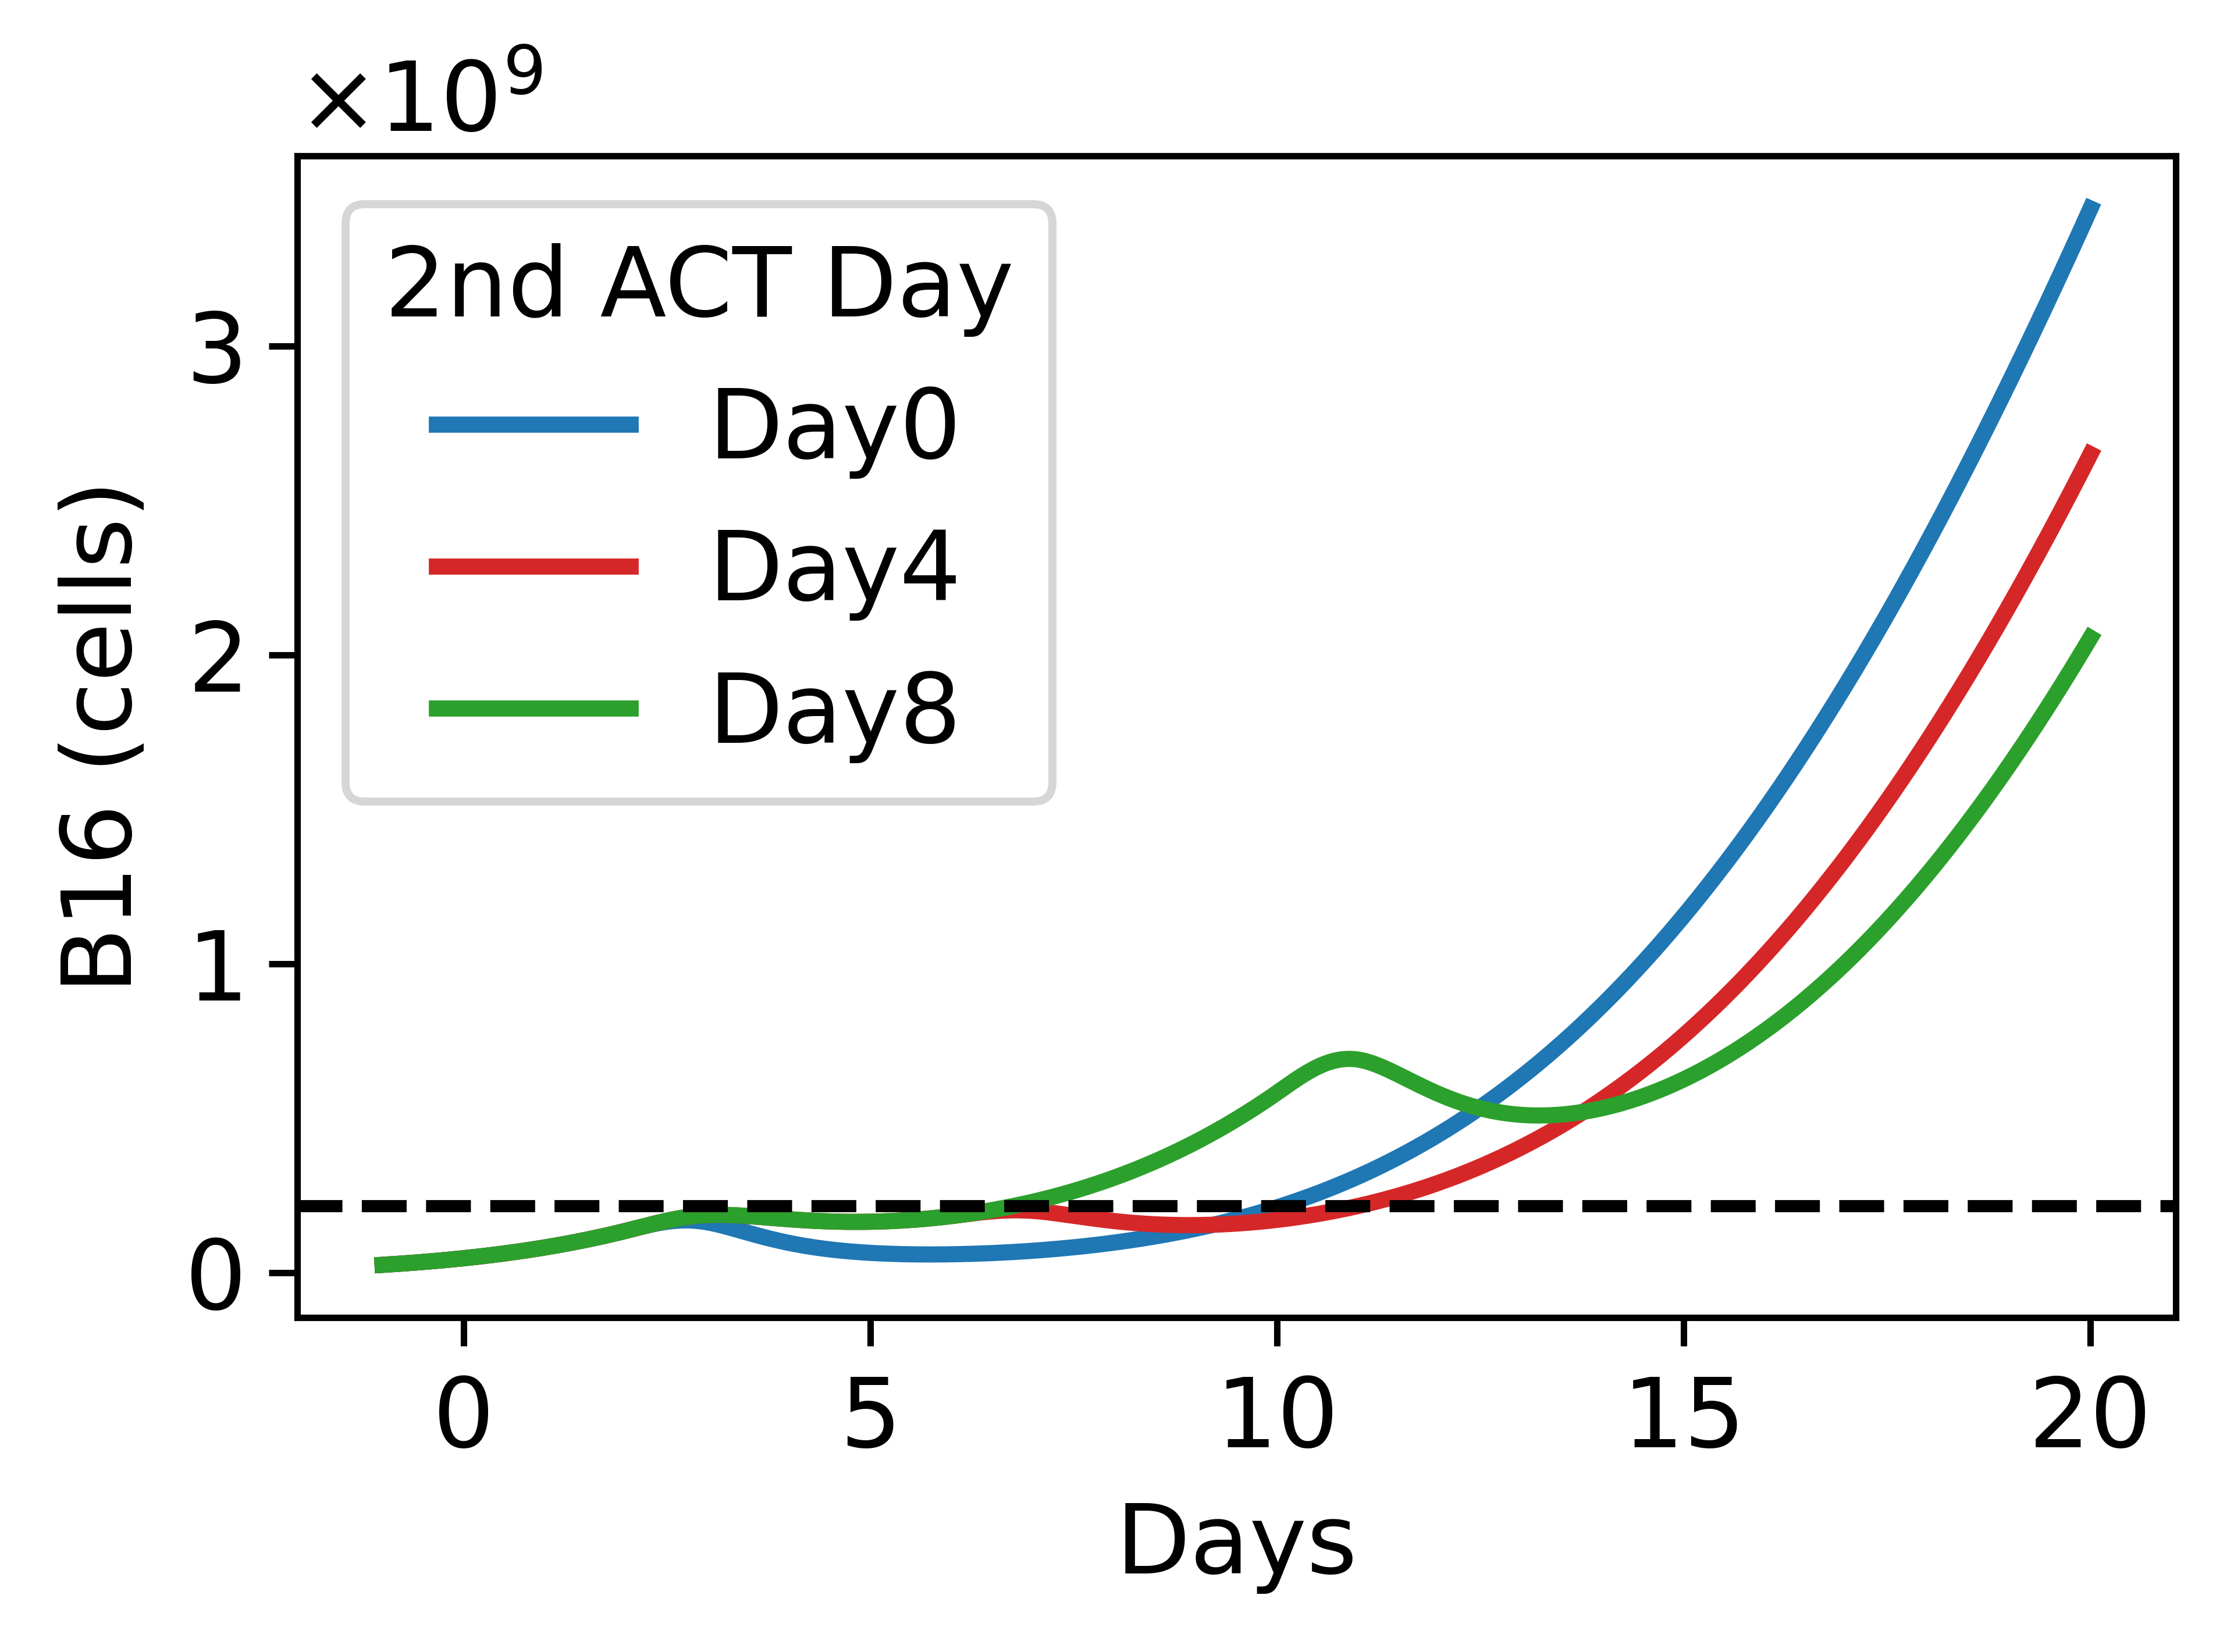

In [42]:
# Time range
y0 = [v_data[0], 0, 0, 0, mdsc_data[0]] # y = [V, E, D, S]
t_eval = np.arange(-1, 20.01, 0.01)

# === Pattern1 ===
dose_list = [1e7, 1e7] 
dose_days = [0, 0]    
delta_t = 1        
sol = odeint(model, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param),
             hmax=0.01)
V_sol, E_sol, D_sol, S_sol, M_sol = sol.T
T_sol = E_sol+D_sol

# === Pattern2 ===
dose_list = [1e7, 1e7] 
dose_days = [0, 4]    
delta_t = 1        
sol2 = odeint(model, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param),
             hmax=0.01)
V_sol2, E_sol2, D_sol2, S_sol2, M_sol2 = sol2.T
T_sol2 = E_sol2+D_sol2

# === Pattern3 ===
dose_list = [1e7, 1e7] 
dose_days = [0, 8]    
delta_t = 1        
sol3 = odeint(model, y0, t_eval, 
             args=(dose_list, dose_days, delta_t, param),
             hmax=0.01)
V_sol3, E_sol3, D_sol3, S_sol3, M_sol3 = sol3.T
T_sol3 = E_sol3+D_sol3

# === Plot ===
plt.figure(figsize=(4, 3), dpi=1000)
plt.rcParams["font.size"] = 12
# --- Panel A: Tumor volume ---
#plt.title('A', loc='left', fontsize=20, fontweight='bold', position=(-0.2,1))
plt.plot(t_eval, V_sol, label='Day0', color='tab:blue', linewidth=2)
plt.plot(t_eval, V_sol2, label='Day4', color='tab:red', linewidth=2)
plt.plot(t_eval, V_sol3, label='Day8', color='tab:green', linewidth=2)
#plt.yscale('log')
plt.axhline(V_ref, linestyle="--", color="black")
plt.xlabel("Days")
plt.ylabel("B16 (cells)")
plt.legend(title='2nd ACT Day')
ax = plt.gca()
set_scientific_yticks(ax)
plt.tight_layout()

pdf_path = os.path.join(dir_path, f"fig3d_PFS_example.pdf")
plt.savefig(pdf_path, dpi=1200)